In [1]:
import chex

chex.set_n_cpu_devices(64)

In [2]:
import functools as ft
import time
from pathlib import Path

import equinox as eqx
import jax
import numpy as np
import pandas as pd
from jax import (
    numpy as jnp,
    random as jr,
    tree as jt,
)
from jaxtyping import Array, Float, Scalar, Shaped

import onlineax
from onlineax.mab.adaptor import (
    MABFromOnline,
)
from onlineax.mab.estimator import importance_weighed_estimator
from onlineax.mab.runner import (
    bernoulli_draws,
    mab_bernoulli_matrix_game_play,
)
from onlineax.map_helper import map_helper as mh
from onlineax.online.algo.tsallis import TsallisFTRL
from onlineax.online.algo.types import EtaRead
from onlineax.pipeline import (
    FixedGameSetup,
    FTRLConfig,
    MABAdaptorConfig,
    MABPipelineOutput,
    mab_game_pipeline,
    online_game_pipeline,
)

In [3]:
from typing import cast

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.axes import Axes
from tqdm.notebook import tqdm

sns.set_theme(
    "paper",
    "darkgrid",
    font_scale=1.1,
    rc={
        "font.family": "serif",
        "font.serif": ["CMU Serif"],
        "axes.facecolor": ".95",
        # math font
        "mathtext.fontset": "cm",
        # tex setting
        "text.usetex": False,
    },
)
%config InlineBackend.figure_format = 'png'

### PSNE game

In [4]:
def planted_game(n, dmin, d):
    first_row = jnp.concatenate(
        [jnp.array([dmin]), jnp.zeros(n - 2) + d]
    ).reshape(1, n - 1)
    upper_tri = jnp.triu(jnp.ones((n - 1, n - 1)), 1)
    mat = jnp.block(
        [
            [0, first_row],
            [jnp.zeros((n - 1, 1)), upper_tri],
        ]
    )
    return ((mat - mat.T) / 2 + 0.5).T


def planted_nash(n, dmin, d):
    return (
        (jnp.arange(n) == 0).astype(float),
        (jnp.arange(n) == 0).astype(float),
    )


def opt(n, dmin, d):
    return 1 / dmin**2 + (n - 2) / d**2


def tsallis_bound(n, dmin, d):
    return 1 / dmin * (1 / dmin + (n - 2) / d)

In [5]:
mab_game_pipeline = jax.jit(
    mab_game_pipeline, static_argnames="max_iter"
)
online_game_pipeline = jax.jit(
    online_game_pipeline, static_argnames="max_iter"
)

In [6]:
@ft.partial(jax.jit, static_argnames=("max_iter", "n_chunk"))
def run_game_predict_manual(game, max_iter, k, n_chunk=131072):
    n, m = game.shape
    learners = (
        TsallisFTRL(n, jnp.array(2.0), jnp.zeros(n)),
        TsallisFTRL(m, jnp.array(2.0), jnp.zeros(m)),
    )
    learners = (
        MABFromOnline(
            online_learner=learners[0],
            estimator=importance_weighed_estimator,
            weights=jnp.zeros(n),
            track_weights=False,
        ),
        MABFromOnline(
            online_learner=learners[0],
            estimator=importance_weighed_estimator,
            weights=jnp.zeros(m),
            track_weights=False,
        ),
    )
    eta = lambda t: EtaRead(2 / jnp.sqrt(t))

    n_outer_iters = max_iter // n_chunk

    def scan_inner(c, a):
        learners, outer_l = c
        key = a
        draw_key, key1, key2 = jr.split(key, 3)
        outer_r = outer_l + n_chunk
        lr_chunk = jax.vmap(eta)(outer_l + jnp.arange(n_chunk) + 1)
        draws = bernoulli_draws(draw_key, n_chunk)
        inputs = (
            (lr_chunk, jr.uniform(key1, (n_chunk,))),
            (lr_chunk, jr.uniform(key2, (n_chunk,))),
        )
        learners, (actions, losses, outputs) = (
            mab_bernoulli_matrix_game_play(
                learners, game, inputs, draws
            )
        )
        c = learners, outer_r
        return c, (actions, outputs)

    outer_l = 0
    loop_key, last_key = jr.split(k, 2)
    (learners, outer_l), (outer_actions, outer_outputs) = jax.lax.scan(
        scan_inner,
        (learners, outer_l),
        jr.split(loop_key, n_outer_iters),
    )
    outer_l = n_outer_iters * n_chunk
    outer_r = max_iter
    lr_chunk = jax.vmap(eta)(jnp.arange(outer_l, outer_r) + 1)
    draw_key, key1, key2 = jr.split(last_key, 3)
    inputs = (
        (lr_chunk, jr.uniform(key1, (outer_r - outer_l,))),
        (lr_chunk, jr.uniform(key2, (outer_r - outer_l,))),
    )
    draws = bernoulli_draws(draw_key, max_iter - outer_l)
    learners, (actions, losses, outputs) = (
        mab_bernoulli_matrix_game_play(learners, game, inputs, draws)
    )
    final_actions = jt.map(
        lambda o, a: jnp.concatenate([o.reshape(-1, *o.shape[2:]), a]),
        outer_actions,
        actions,
    )
    return (
        (final_actions[0] == 0).cumsum() / jnp.arange(1, max_iter + 1)
        > 0.5
    ) & (
        (final_actions[1] == 0).cumsum() / jnp.arange(1, max_iter + 1)
        > 0.5
    )

In [7]:
learner_config = FTRLConfig(
    TsallisFTRL,
    lambda t: 2 / jnp.sqrt(t),
)

k = jr.key(42)
n_repeats = 512

vec = "avg"


# @ft.partial(jax.jit, static_argnames="max_iter")
def run_game_multi_predict(game, max_iter, k):
    correct = (
        mh(ft.partial(run_game_predict_manual, game, max_iter))
        .s(-1)
        .p(64)(jr.split(k, n_repeats))
    )
    z = jt.map(lambda x: x.mean(axis=0), correct)
    return z


def get_correct_maiti(n, dmin, dother, k):
    ov = opt(n, dmin, dother)
    game = planted_game(n, dmin, dother)
    n_iter = int(ov * 256)
    correct = run_game_multi_predict(game, n_iter, k)
    return correct

In [8]:
def time_estimate(n, d1, d2):
    return tsallis_bound(n, d1, d2) * n


def ov_time_estimate(n, d1, d2):
    return 256 * opt(n, d1, d2) * n


minute_time = 2 * time_estimate(256, 0.03, 0.1) / 0.7


def time_rel(n, d1, d2):
    return time_estimate(n, d1, d2) / minute_time


def ov_time_rel(n, d1, d2):
    return ov_time_estimate(n, d1, d2) / minute_time

In [9]:
def second_cost_estimate(n, d1):
    return int(round(ov_time_rel(n, d1 * 2, 0.1 * 2) * 60 + 1))


d1s = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
ns = [4, 16, 64, 256]
# d1s = [0.05, 0.1]
# ns = [4, 6]

configs = sorted(
    [
        (n, d1, f"{n}_{d1}", second_cost_estimate(n, d1))
        for n in ns
        for d1 in d1s
    ],
    key=lambda x: -x[-1],
)

save_path = Path("psne_results")

total_cost = sum([cost for _, _, _, cost in configs])

In [10]:
save_path.mkdir(exist_ok=True, parents=True)
time_records = []

with tqdm(total=total_cost) as pbar:
    for n, d1, name, cost in configs:
        pbar.set_description(name)
        save_file = save_path / f"{name}.data"
        seed_int = int((n + d1) * 1000000)
        before_time = time.time()
        data = get_correct_maiti(n, d1 * 2, 0.1 * 2, jr.key(seed_int))
        jnp.save(save_file, data, allow_pickle=False)
        after_time = time.time()
        time_used = after_time - before_time
        print(f"{n=} {d1=} {time_used=}")
        time_records.append((n, d1, name, cost, time_used))
        pbar.update(cost)

df_time = pd.DataFrame(
    time_records, columns=["n", "d1", "name", "cost", "time"]
)

  0%|          | 0/30109 [00:00<?, ?it/s]

n=256 d1=0.001 time_used=6158.592080354691
n=256 d1=0.002 time_used=1522.852662563324
n=64 d1=0.001 time_used=3079.9372024536133
n=256 d1=0.005 time_used=372.9515495300293
n=64 d1=0.002 time_used=759.4220721721649
n=16 d1=0.001 time_used=1912.392468214035
n=256 d1=0.01 time_used=205.61258387565613
n=256 d1=0.02 time_used=157.38609719276428
n=256 d1=0.05 time_used=145.3078465461731
n=256 d1=0.1 time_used=143.91163182258606
n=16 d1=0.002 time_used=509.84885716438293
n=4 d1=0.001 time_used=1595.180986404419
n=64 d1=0.005 time_used=133.9870572090149
n=64 d1=0.01 time_used=48.737767934799194
n=4 d1=0.002 time_used=393.7240216732025
n=16 d1=0.005 time_used=77.54346251487732
n=64 d1=0.02 time_used=26.160731554031372
n=64 d1=0.05 time_used=21.276669025421143
n=64 d1=0.1 time_used=19.43608856201172
n=16 d1=0.01 time_used=22.131054162979126
n=4 d1=0.005 time_used=68.52185201644897
n=16 d1=0.02 time_used=13.071709156036377
n=4 d1=0.01 time_used=18.11234211921692
n=16 d1=0.05 time_used=4.411324024

In [11]:
# re-load the data and prepare for plotting

configs = [
    (n, d1, f"{n}_{d1}")
    for n in [256]
    for d1 in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
    # for n in [4]
    # for d1 in [0.05, 0.1]
]

dfs = []


def smooth_data(data, idx):
    data = data.cumsum()
    return (data[idx[1:]] - data[idx[:-1]]) / (idx[1:] - idx[:-1])


for n, d1, name in configs:
    save_file = save_path / f"{name}.data.npy"
    data = np.load(save_file).astype(np.float64)
    tb = tsallis_bound(n, d1 * 2, 0.1 * 2)
    h1 = opt(n, d1 * 2, 0.1 * 2)
    xs = np.arange(data.shape[0]) / h1
    x_ind = np.rint(np.linspace(0, data.shape[0] - 1, 100)).astype(
        np.int32
    )
    df = pd.DataFrame(
        {
            "x": xs[x_ind[:-1]] / 2,
            "y": smooth_data(data, x_ind),
            "name": name,
        }
    )
    dfs.append(df)

bin_width = 2
df = pd.concat(dfs)
df["rounded_x"] = (
    np.rint(df["x"] / bin_width).astype(np.int32) * bin_width
)

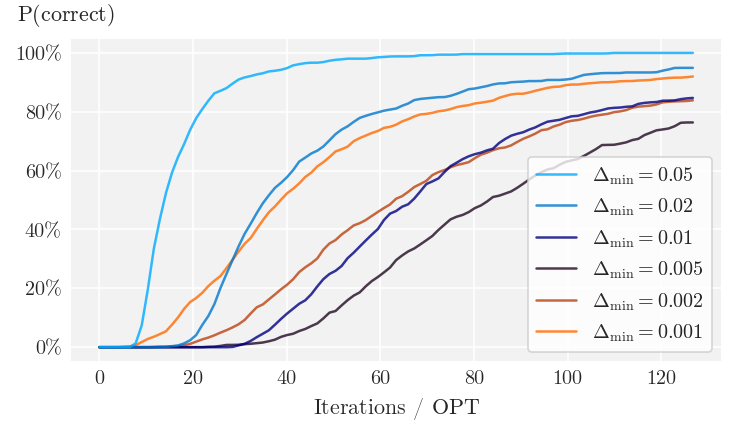

In [12]:
# plot the data

fig, ax = plt.subplots(
    1,
    1,
    figsize=(6 * 0.8, 3.5 * 0.8),
    dpi=150,
    layout="constrained",
    sharey=True,
    sharex=True,
)
palette = [
    "#00AAFF",
    "#0077CC",
    "#000080",
    "#230A23",
    "#BB4311",
    "#FF6B00",
]
sns.lineplot(
    data=df,
    x="x",
    y="y",
    hue="name",
    ax=ax,
    errorbar=("pi", 0.9),
    alpha=0.8,
    palette=palette[::-1],
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    facecolor="white",
    handles=handles[::-1],
    labels=[f"$\\Delta_\\mathrm{{min}}={s[4:]}$" for s in labels][::-1],
)
ax.set_xlabel("Iterations / $\\mathrm{OPT}$")
ax.set_ylabel(
    "$\\mathrm{P}(\\mathrm{correct})$",
    rotation="horizontal",
    horizontalalignment="left",
    y=1.03,
    labelpad=-1,
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.tick_params(axis="both", which="major", pad=-1)
fig.patch.set_facecolor("white")
plt.savefig(
    "identify_P_vs_iterations_by_H1.pdf",
    bbox_inches="tight",
    facecolor=fig.get_facecolor(),
    edgecolor="none",
)

### Discrepancy

The code is different yet equivalent to the description in
the preprint in the following ways:

- The paper assumes the feedback is in the range of $[-1, 1]$,
  while the code assumes the feedback is in the range of
  $[0, 1]$. In the code, everything is scaled accordingly,
  including the game matrix, the learning rate, and the regret.
- The regularizer in the code is 2 times the regularizer in the
  paper. The learning rate is also scaled by a factor of 2, so
  the effect cancels out.

The plotting script accounts for these discrepancies and scales
the axis accordingly, making the output figures consistent with
the paper.